# Final Project Proximal Policy Optimization

Original code wrote by:
Joseph Distefano(jpdistef@buffalo.edu)


In [1]:
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install gym
# !pip install random 
# !pip install time
# !pip install box2d-py

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import time
import math


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, namedtuple
from torch.distributions import Categorical

# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline


In [5]:
class Critic(nn.Module):
    def __init__(self,state_size,action_size):
        super(Critic,self).__init__()
        self.linear1 = nn.Linear(state_size,32)
        self.linear2 = nn.Linear(32,64)
        self.linear3 = nn.Linear(64,1)
        
    def forward(self,state):
        out = F.relu(self.linear1(state))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out
        
class Actor(nn.Module):
    def __init__(self,state_size,action_size):
        super(Actor,self).__init__()
        self.linear1 = nn.Linear(state_size,32)
        self.linear2 = nn.Linear(32,64)
        self.linear3 = nn.Linear(64,action_size)
        self.softmax = nn.Softmax()
        
    def forward(self,state):
        out = F.relu(self.linear1(state))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        out = self.softmax(out)
        return out
        

In [6]:
class Replay_Memory:  
    def __init__(self):
        self.actions,self.states,self.next_state,self.logprobs,self.rewards,self.done = [],[],[],[],[],[]

    def clear_mem(self):
        del self.actions[:],self.next_state[:],self.states[:],self.logprobs[:],self.rewards[:],self.done[:]
        
    def update(self,reward, done):
        self.rewards.append(reward)
        self.done.append(done)

In [7]:
class PPOagent():
    def __init__(self,state_size,action_size,lr,betas,epochs,eps_clip,gamma):
        self.actor = Actor(state_size,action_size) 
        self.critic = Critic(state_size,action_size)
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=lr,betas=betas)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=lr)
        self.Mseloss = nn.MSELoss()
        self.epochs = epochs
        self.epsclip = eps_clip
        self.gamma = gamma
        
    def get_action(self,state,memory):
        state = torch.from_numpy(state).float()
        prob = self.actor.forward(state)
        dist = torch.distributions.Categorical(probs=prob)
        action = dist.sample()
        memory.logprobs.append(dist.log_prob(action))
        memory.actions.append(action)
        memory.states.append(state)
        return action,dist
    
    def update(self,memory):
        rewards = []
        Gt = 0 
        for reward, done in zip(reversed(memory.rewards),reversed(memory.done)):
            if done:
                Gt = 0
            Gt = reward + (self.gamma*Gt)
            rewards.insert(0,Gt)
            
#         states = torch.FloatTensor(memory.states).detach()
#         print(actions)
#         actions = torch.FloatTensor(memory.actions).detach()
#         logprobs = torch.FloatTensor(memory.logprobs).detach()

        states = torch.stack(memory.states).detach()
        actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()
                              
        for _ in range(self.epochs):
            action_probs = self.actor.forward(states)
            dist = Categorical(action_probs)
            action_logprobs = dist.log_prob(actions)
            dist_entropy = dist.entropy()
            state_value = self.critic.forward(states)
            state_value = torch.squeeze(state_value)
               
            ratio = torch.exp(action_logprobs - old_logprobs.detach())
                
            advantage = rewards - state_value.detach()
            loss1 = ratios * advantages
            loss2 = torch.clamp(ratio, 1-self.epsclip, 1+self.epsclip) * advantage
            loss = -torch.min(loss1, loss2) + 0.5*self.Mseloss(state_value, rewards) - 0.01*dist_entropy
            
            self.optimizer_actor.zero_grad()
            loss.mean().backward()
            self.optimizer_actor.step()    
    

In [8]:
env = gym.make("CartPole-v1")
env.reset()
# plt.imshow(env.render('rgb_array'))

state_size = env.observation_space.shape[0]
action_size = env.action_space.n


In [9]:
env = gym.make('LunarLander-v2')
env.reset()
# plt.imshow(env.render('rgb_array'))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [8]:
num_episodes = 2000
lr = 0.001
gamma = 0.99
update_timestep = 1000
betas = (0.9, 0.999)
K_epochs = 4               
eps_clip = 0.2             
agent = PPOagent(state_size, action_size,lr, betas, K_epochs, eps_clip,gamma)

memory = Replay_Memory()

episode_rewards = []
rewards = []
timestep = 0
for episode in range(num_episodes):
    state = env.reset()
    rewards = []
    done = False
    logprobs = []

    while not done:
        timestep += 1
        action = agent.get_action(state,memory)
        next_state, reward, done, info = env.step(action[0].detach().data.numpy())
        memory.update(reward, done)
        rewards.append(reward)
        state = next_state
        
        
        if timestep % update_timestep == 0:
            agent.update(memory)
            memory.clear_mem()
            timestep = 0
        
        
        if done:
            break

    episode_rewards.append(np.sum(rewards))
    if episode % 100 == 0:
        
        print('Episode {}'.format(episode))
        print('Last Episode Reward: {}'.format(np.sum(rewards)))
        print('-'*10)




/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 0
Last Episode Reward: 13.0
----------


/home/josephdistefano/snap/jupyter/common/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Episode 100
Last Episode Reward: 18.0
----------
Episode 200
Last Episode Reward: 11.0
----------
Episode 300
Last Episode Reward: 78.0
----------
Episode 400
Last Episode Reward: 66.0
----------
Episode 500
Last Episode Reward: 79.0
----------
Episode 600
Last Episode Reward: 205.0
----------
Episode 700
Last Episode Reward: 120.0
----------
Episode 800
Last Episode Reward: 203.0
----------
Episode 900
Last Episode Reward: 500.0
----------
Episode 1000
Last Episode Reward: 500.0
----------
Episode 1100
Last Episode Reward: 432.0
----------
Episode 1200
Last Episode Reward: 480.0
----------
Episode 1300
Last Episode Reward: 500.0
----------
Episode 1400
Last Episode Reward: 500.0
----------
Episode 1500
Last Episode Reward: 500.0
----------
Episode 1600
Last Episode Reward: 466.0
----------
Episode 1700
Last Episode Reward: 500.0
----------
Episode 1800
Last Episode Reward: 500.0
----------
Episode 1900
Last Episode Reward: 500.0
----------


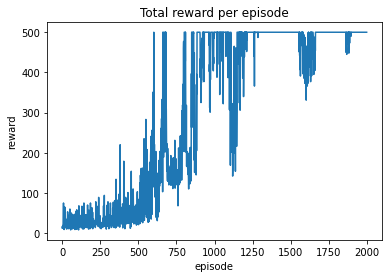

In [9]:
plt.plot(episode_rewards)
plt.title("Total reward per episode")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [10]:
np.save('PPO_cartpole',episode_rewards)

In [44]:
x = np.load('PPO_LunarLander.npy')

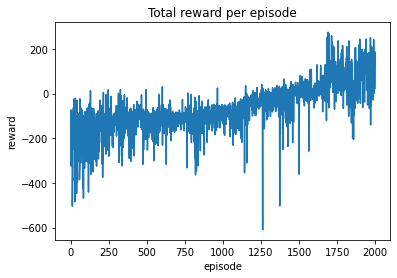